In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
import os

# Define indicators and their normalization direction (1=normal, -1=inverted)
indicators = {
    "Ökologie": {
        "Siedlungs- und Verkehrsfläche": -1, 
        "Abfallmenge": -1,  
        "Naturnähere Fläche je Einwohner": 1,  
        "Nahversorgung Haltestellen des ÖV Anteil der Bev. 1km Radius": 1 
    },
    "Ökonomie": {
        "Bruttoinlandsprodukt je Einwohner": 1,  
        "Arbeitslosenquote": -1,  
        "Beschäftigte in wissensintensiven Industrien": 1,
        "Steuerkraft": 1  
    },
    "Soziales": {
        "SGB II-/SGB XII-Quote": -1,  
        "Schulabgänger ohne Abschluss": -1,
        "Einwohner je Arzt": -1,  
        "Wahlbeteiligung": 1  
    }
}

def parse_csv(file_path="Inkar-Abfrage.csv"):
    """Parse the CSV file and return a cleaned dataframe"""
    try:
        # Read the CSV file with column names from first row, skipping the year row
        with open(file_path, "r", encoding="utf-8") as f:
            headers = f.readline().strip().split(";")
            
        # Now read the data, skipping both header rows
        df = pd.read_csv(file_path, sep=";", header=None, skiprows=2, names=headers)
        print(f"Successfully loaded data with {len(df)} cities")
        print(f"Available columns: {df.columns.tolist()}")
        
        # Convert string values to numeric
        for col in df.columns[3:]:
            # Fix German number format: first remove thousands separator (.) then replace decimal comma (,)
            df[col] = pd.to_numeric(
                df[col].astype(str)
                       .str.replace(".", "", regex=False)  # Remove thousands separator dots
                       .str.replace(",", ".", regex=False),  # Convert decimal commas to dots
                errors="coerce"
            )
            # Debug: Check for NaN values in each column
            nan_count = df[col].isna().sum()
            if nan_count > 0:
                print(f"Column '{col}' has {nan_count} NaN values")
        
        return df
    except Exception as e:
        print(f"Error loading CSV: {e}")
        return None

def create_indicator_mapping(df, indicators):
    """Create mapping between indicator names and actual column names"""
    column_mapping = {}
    for dimension_indicators in indicators.values():
        for indicator_name in dimension_indicators.keys():
            # Try to find a matching column (exact or partial match)
            exact_match = indicator_name in df.columns
            if exact_match:
                column_mapping[indicator_name] = indicator_name
            else:
                # Look for partial matches
                matches = [col for col in df.columns if indicator_name in col]
                if matches:
                    column_mapping[indicator_name] = matches[0]
                    print(f"Mapped '{indicator_name}' to '{matches[0]}'")
                else:
                    print(f"WARNING: No match found for indicator '{indicator_name}'")
    
    print("Column mapping:", column_mapping)
    return column_mapping

def calculate_sustainability_scores(df, indicators, column_mapping):
    """Calculate sustainability scores based on indicators"""
    # Calculate dimension scores
    results = {}
    
    # Add identifier columns to results
    if "Kennziffer" in df.columns:
        results["Kennziffer"] = df["Kennziffer"]
    if "Raumeinheit" in df.columns:
        results["Raumeinheit"] = df["Raumeinheit"]
    elif "Name" in df.columns:  # Try alternative column name
        results["Raumeinheit"] = df["Name"]
    else:
        # If no identifier columns exist, use row index
        results["ID"] = df.index
    
    all_dimension_scores = []
    # Calculate scores for each dimension
    for dimension, dimension_indicators in indicators.items():
        print(f"\nProcessing dimension: {dimension}")
        dimension_scores = []
        
        for indicator, direction in dimension_indicators.items():
            # Use column mapping if available, otherwise try direct column name
            column_name = column_mapping.get(indicator, indicator)
            if column_name not in df.columns:
                print(f"WARNING: Column '{column_name}' not found, using zeros")
                values = np.zeros(len(df))
            else:
                values = df[column_name].values
            
            # Handle NaN values in min/max calculation
            valid_values = values[~np.isnan(values)]
            if len(valid_values) == 0:
                print(f"WARNING: All values for {column_name} are NaN, using default range")
                min_val = 0
                max_val = 100
            else:
                min_val = np.nanmin(values)
                max_val = np.nanmax(values)
            
            print(f"  Indicator: {indicator}, NaN count: {np.isnan(values).sum()} of {len(values)}")
            
            if min_val == max_val:
                normalized = np.full_like(values, 50)  # Neutral score if all values are equal
            else:
                normalized = 100 * (values - min_val) / (max_val - min_val)
                
                # For inverted indicators, we need to flip the scale
                if direction == -1:
                    normalized = 100 - normalized
            
            dimension_scores.append(normalized)
        
        # Average all indicator scores within this dimension using nanmean to handle NaNs
        dimension_scores_array = np.array(dimension_scores)
        dimension_avg = np.nanmean(dimension_scores_array, axis=0)
        print(f"  {dimension} dimension scores shape: {dimension_scores_array.shape}")
        print(f"  {dimension} NaNs in final average: {np.isnan(dimension_avg).sum()} of {len(dimension_avg)}")
        results[f"{dimension}-Score"] = dimension_avg
        all_dimension_scores.append(dimension_avg)
    
    # Create results DataFrame
    result_df = pd.DataFrame(results)
    
    # Round scores to 2 decimal places
    score_columns = [col for col in result_df.columns if col.endswith("-Score") or col == "Gesamtscore"]
    result_df[score_columns] = result_df[score_columns].round(2)
    
    return result_df

def calculate_and_save_scores(file_path="Inkar-Abfrage.csv", output_file="sustainability_scores.csv"):
    """Main function to orchestrate the entire process"""
    # Parse CSV
    df = parse_csv(file_path)
    if df is None:
        return
    
    # Create column mapping
    column_mapping = create_indicator_mapping(df, indicators)
    
    # Calculate scores
    result_df = calculate_sustainability_scores(df, indicators, column_mapping)
    
    # Save to CSV
    result_df.to_csv(output_file, sep=";", index=False)
    print(f"Sustainability scores saved to {output_file}")
    return df, column_mapping


df, column_mapping = calculate_and_save_scores()

Successfully loaded data with 13 cities
Available columns: ['\ufeffKennziffer', 'Raumeinheit', 'Aggregat', 'Abfallmenge', 'Naturnähere Fläche je Einwohner', 'Nahversorgung Haltestellen des ÖV Anteil der Bev. 1km Radius', 'Bruttoinlandsprodukt je Einwohner', 'Arbeitslosenquote', 'Schulabgänger ohne Abschluss', 'Einwohner je Arzt', 'SGB II-/SGB XII-Quote', 'Beschäftigte in wissensintensiven Industrien', 'Steuerkraft', 'Wahlbeteiligung', 'Siedlungs- und Verkehrsfläche']
Column mapping: {'Siedlungs- und Verkehrsfläche': 'Siedlungs- und Verkehrsfläche', 'Abfallmenge': 'Abfallmenge', 'Naturnähere Fläche je Einwohner': 'Naturnähere Fläche je Einwohner', 'Nahversorgung Haltestellen des ÖV Anteil der Bev. 1km Radius': 'Nahversorgung Haltestellen des ÖV Anteil der Bev. 1km Radius', 'Bruttoinlandsprodukt je Einwohner': 'Bruttoinlandsprodukt je Einwohner', 'Arbeitslosenquote': 'Arbeitslosenquote', 'Beschäftigte in wissensintensiven Industrien': 'Beschäftigte in wissensintensiven Industrien', 'Steu


Creating indicator visualizations...
Visualization saved as 'indicators_heatmap.png'
Visualization for Ökologie saved as 'Ökologie_indicators.png'
Visualization for Ökonomie saved as 'Ökonomie_indicators.png'
Visualization for Soziales saved as 'Soziales_indicators.png'


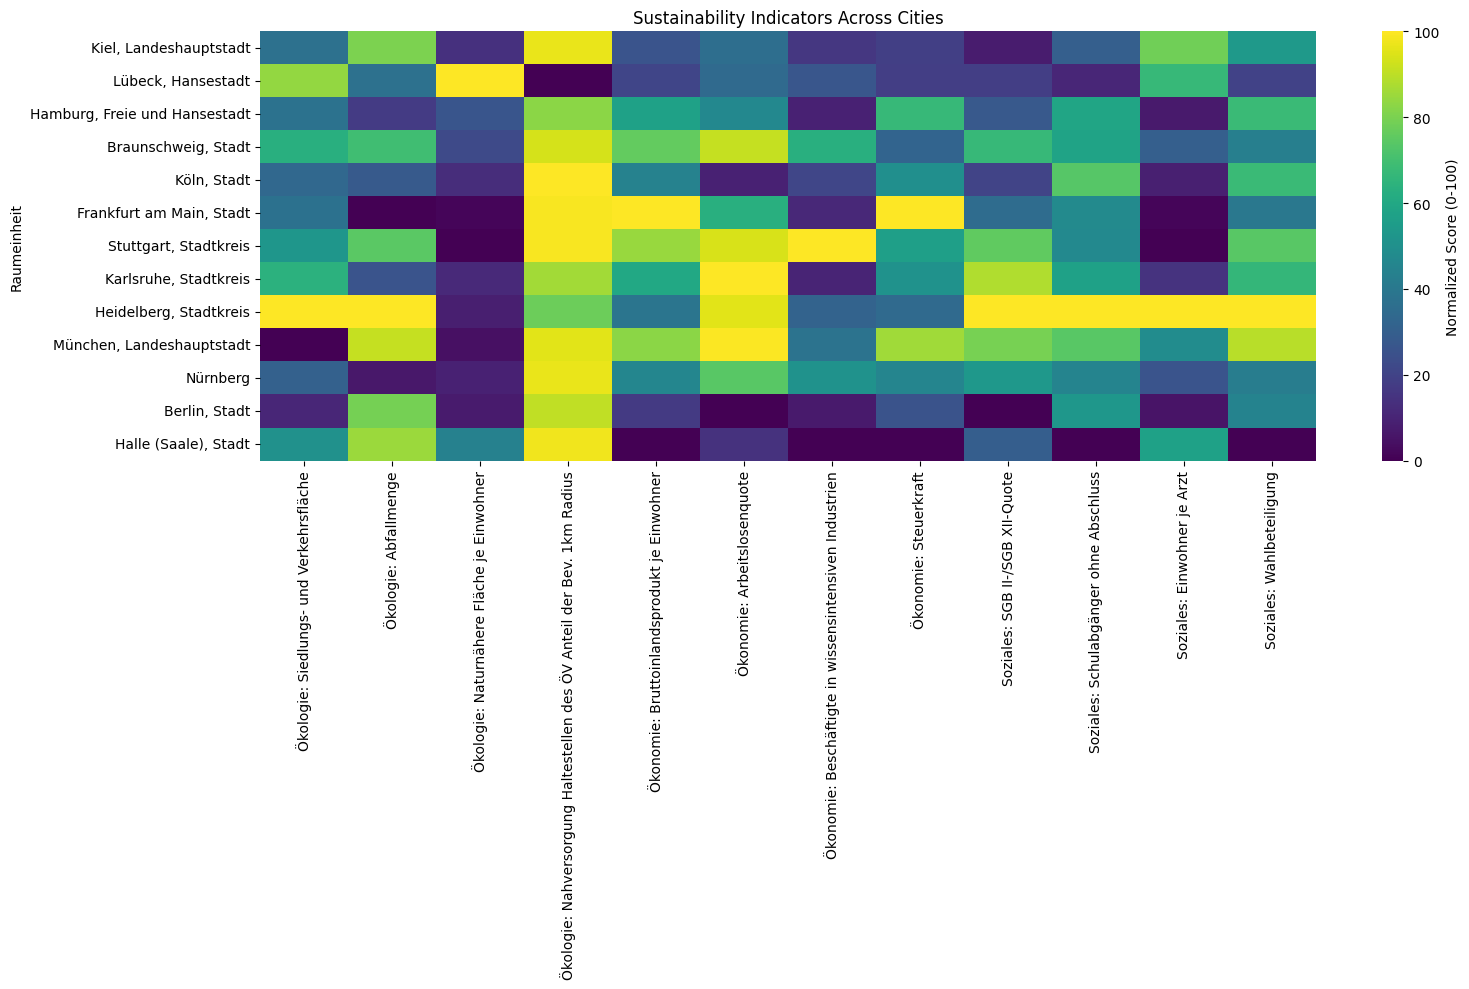

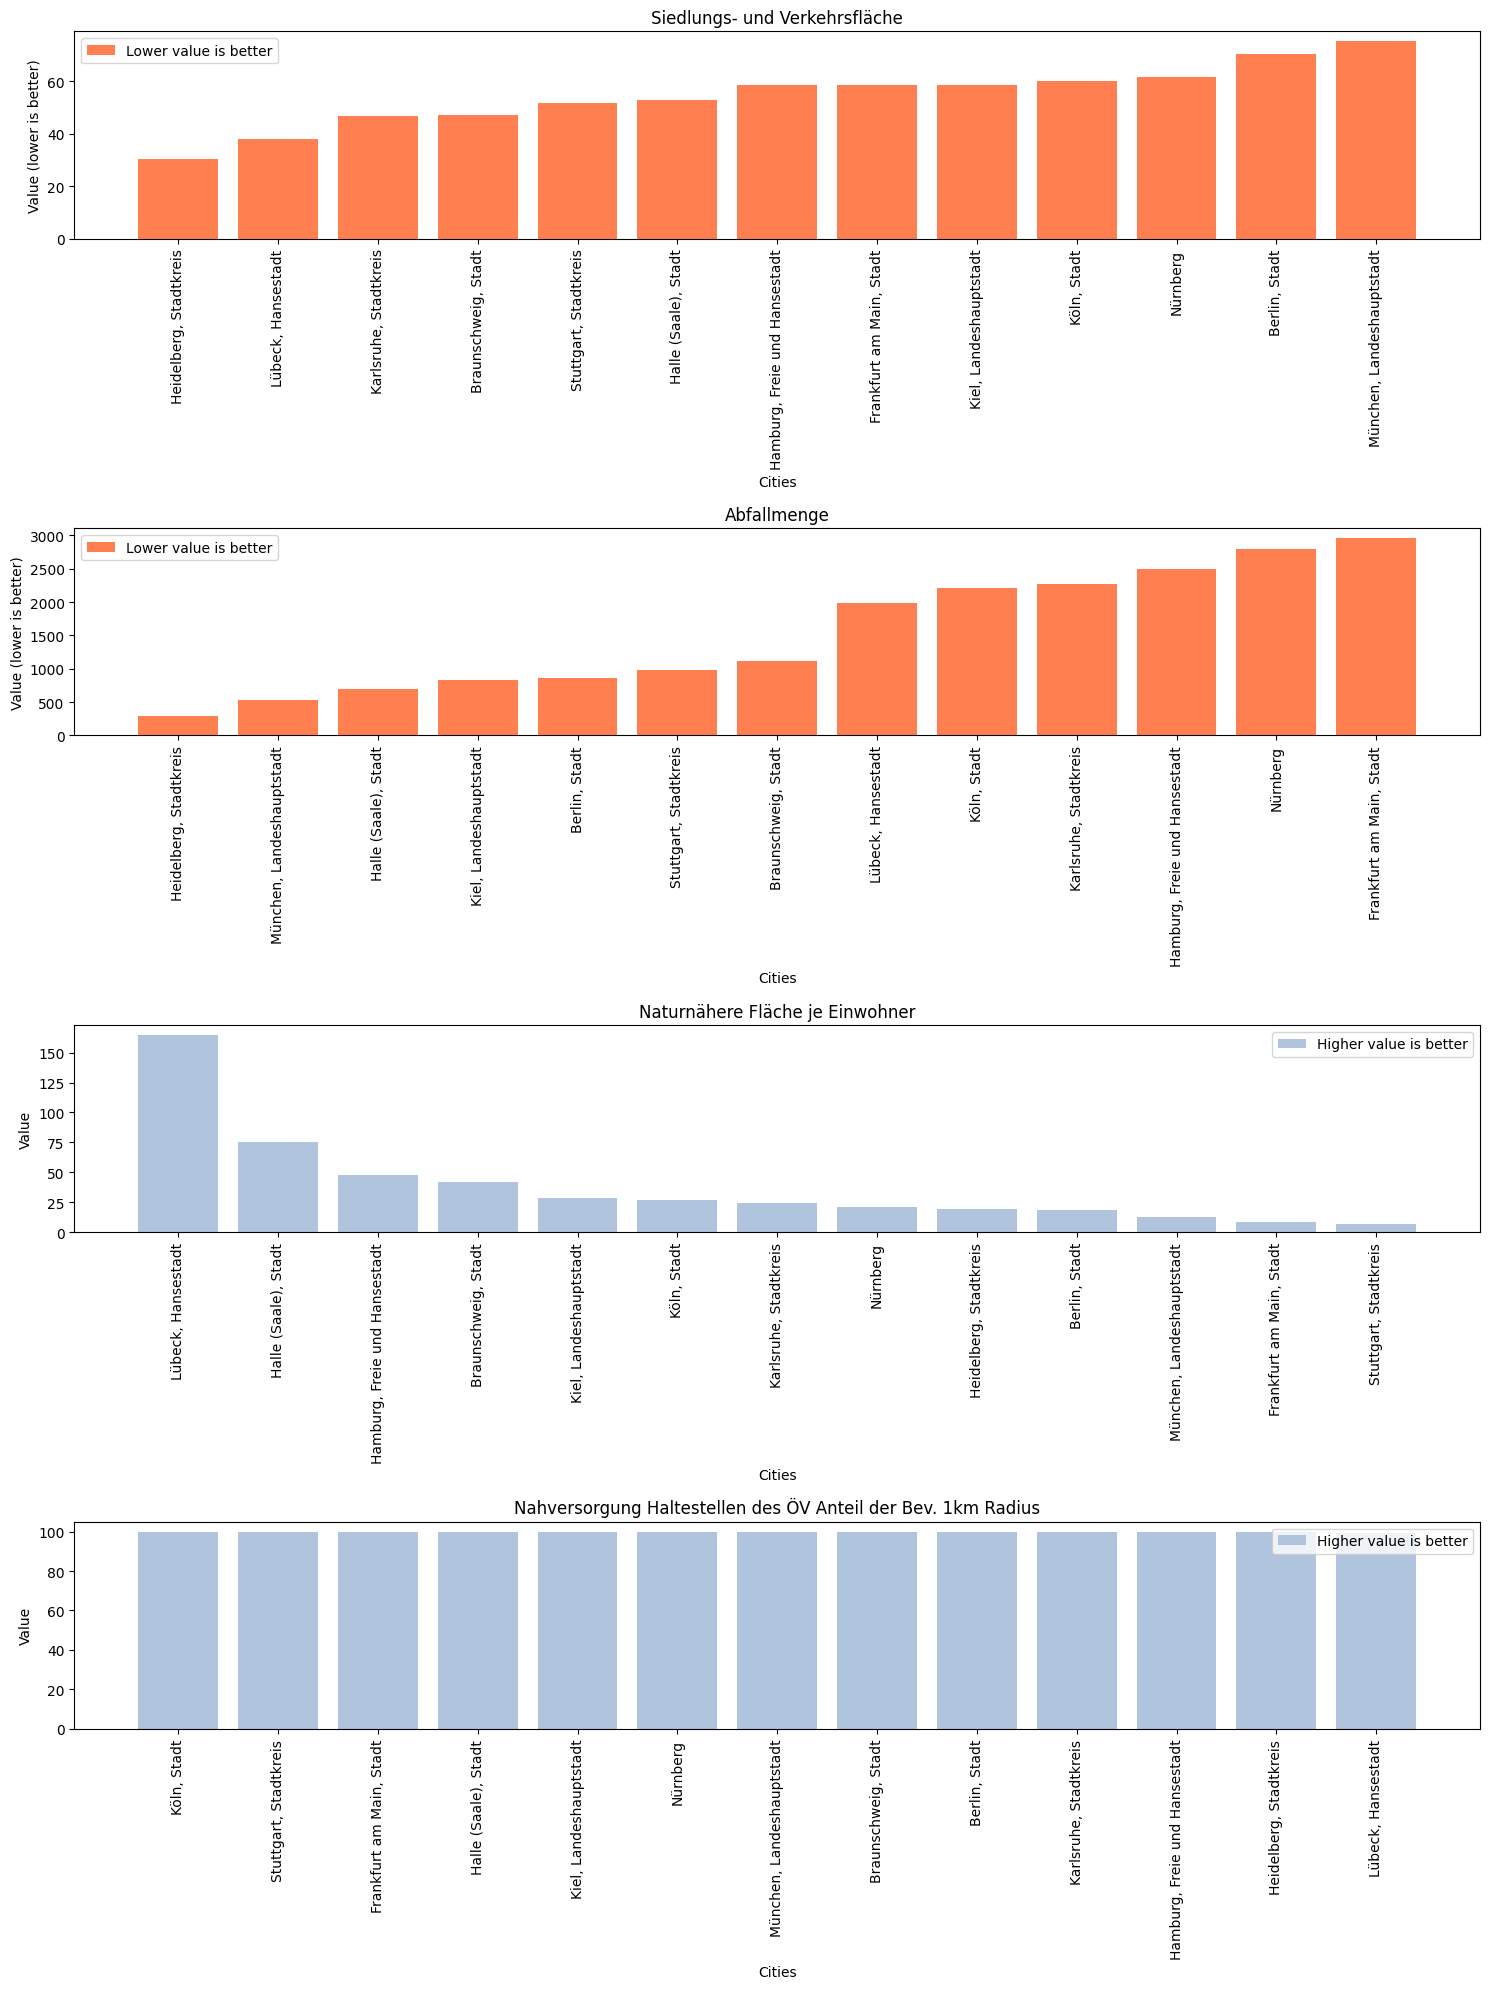

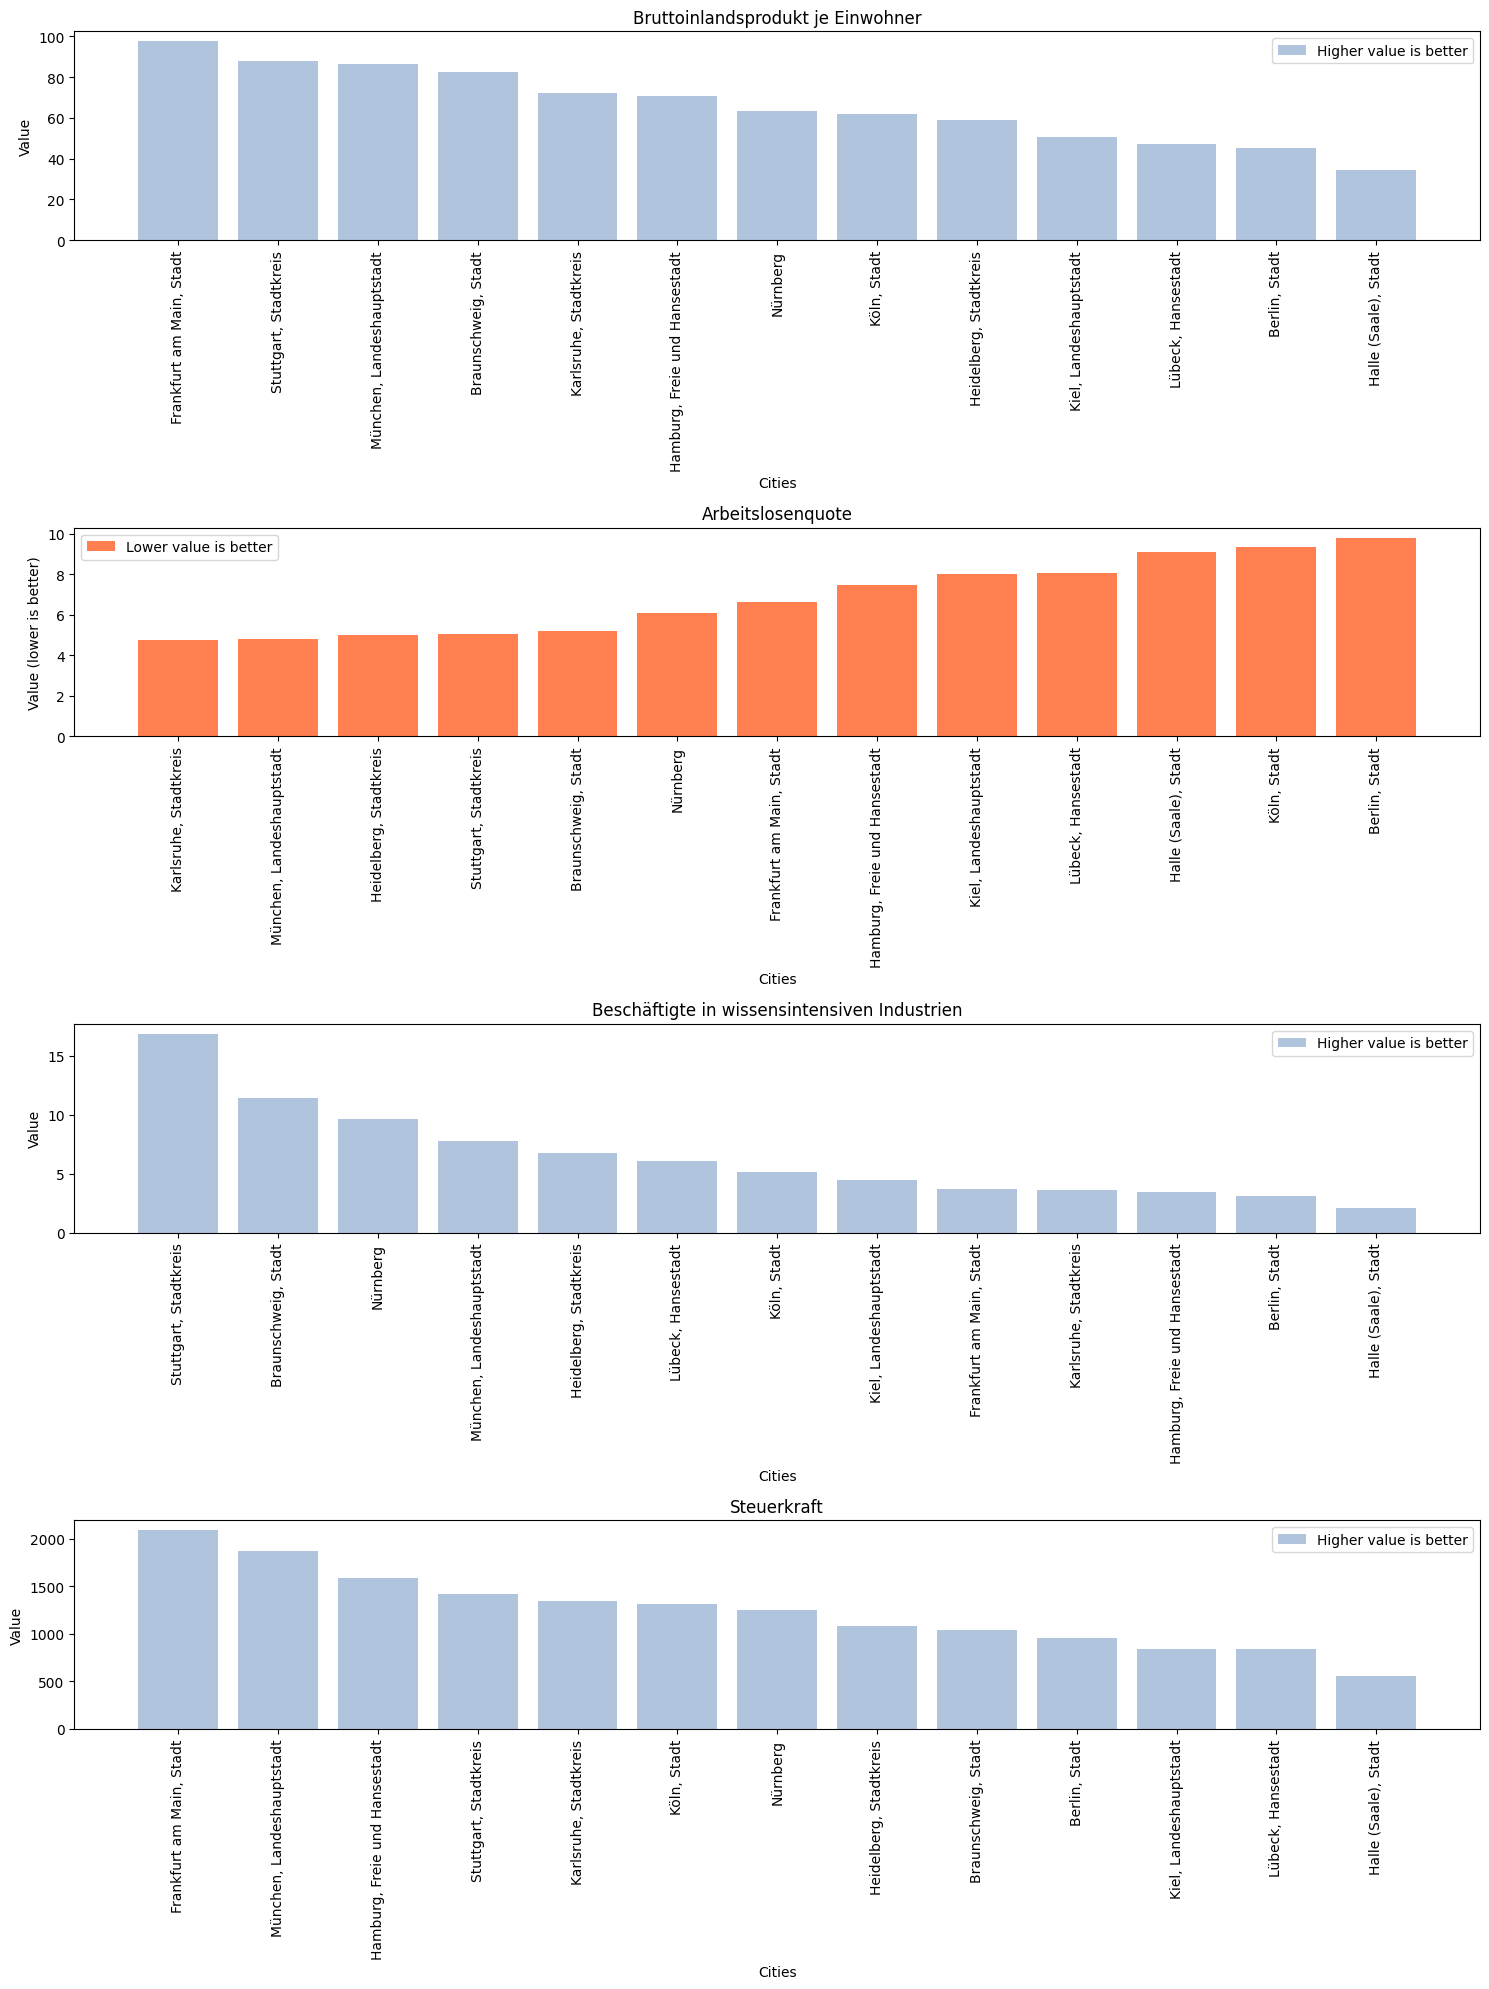

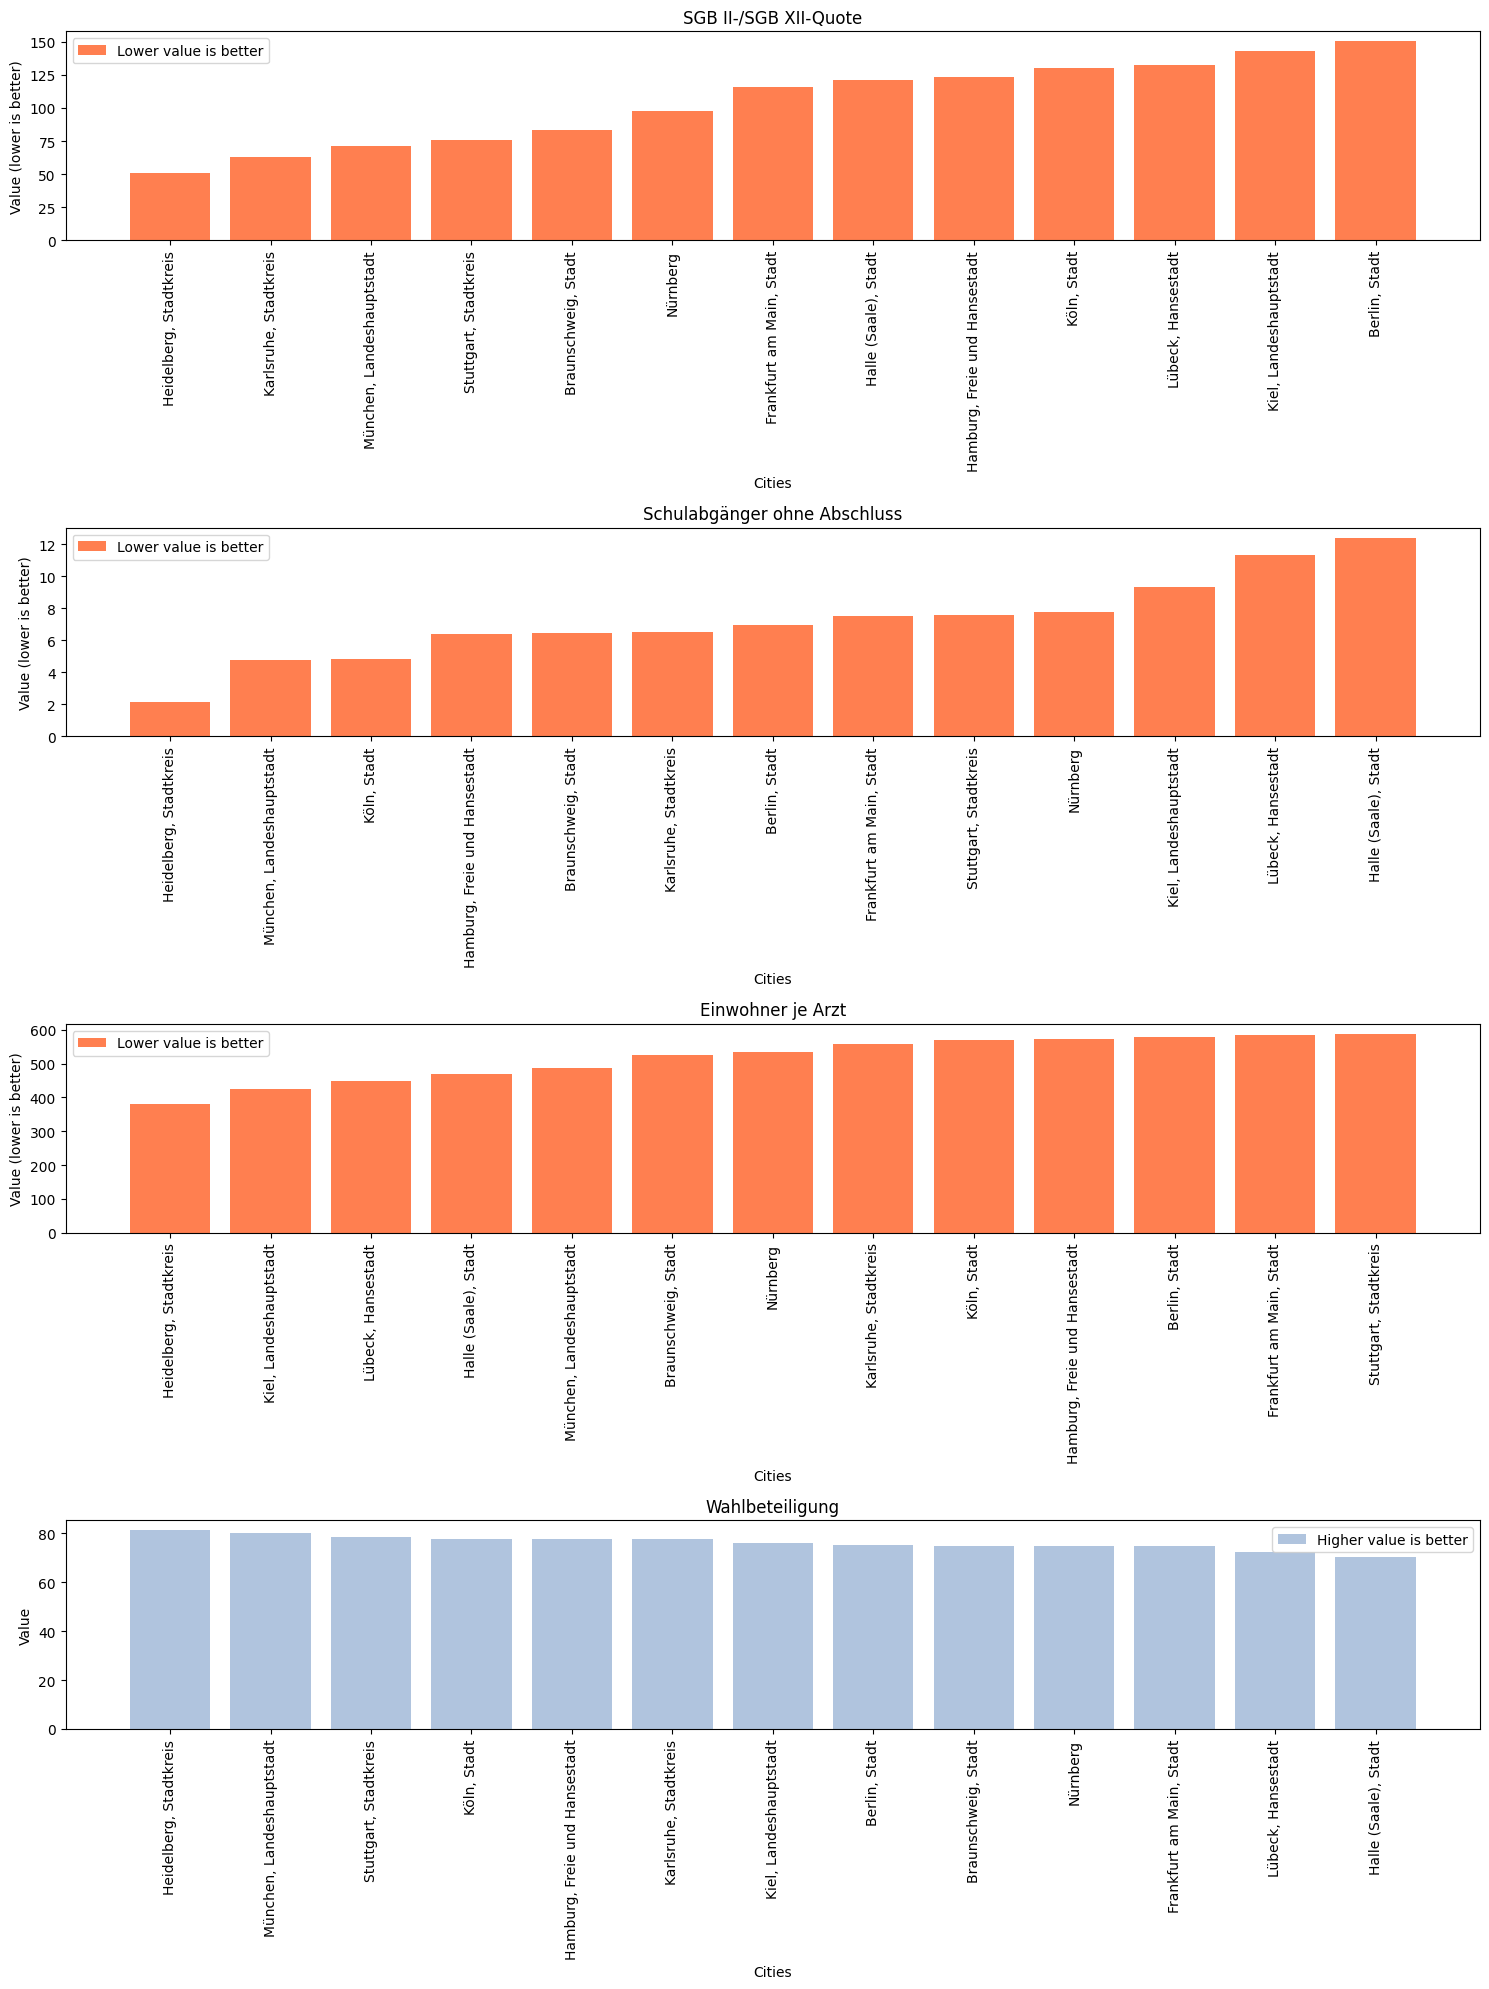

In [7]:
def plot_indicators(df, column_mapping, indicators):
    """Create visualizations for all indicators across cities"""
    print("\nCreating indicator visualizations...")
    
    # Get city names
    city_column = "Raumeinheit" if "Raumeinheit" in df.columns else "Name"
    if city_column not in df.columns:
        print("City column not found, using row numbers as city identifiers")
        df["City"] = [f"City {i}" for i in range(len(df))]
        city_column = "City"
    
    # Create a heatmap of normalized indicator values
    plt.figure(figsize=(16, max(10, len(df)//5)))
    
    # Prepare data for heatmap
    heatmap_data = {}
    for dimension, dim_indicators in indicators.items():
        for indicator_name, direction in dim_indicators.items():
            column_name = column_mapping.get(indicator_name, indicator_name)
            if column_name in df.columns:
                # Normalize the data for better visualization
                values = df[column_name].values
                valid_values = values[~np.isnan(values)]
                if len(valid_values) > 0 and np.nanmin(valid_values) != np.nanmax(valid_values):
                    min_val = np.nanmin(values)
                    max_val = np.nanmax(values)
                    normalized = 100 * (values - min_val) / (max_val - min_val)
                    
                    # For inverted indicators, flip the scale
                    if direction == -1:
                        normalized = 100 - normalized
                        
                    heatmap_data[f"{dimension}: {indicator_name}"] = normalized
    
    # Create DataFrame for heatmap
    if heatmap_data:
        heatmap_df = pd.DataFrame(heatmap_data, index=df[city_column])
        
        # Plot heatmap
        sns.heatmap(heatmap_df, cmap="viridis", cbar_kws={'label': 'Normalized Score (0-100)'})
        plt.title("Sustainability Indicators Across Cities")
        plt.tight_layout()
        os.makedirs("plots", exist_ok=True)
        plt.savefig(os.path.join("plots", "indicators_heatmap.png"), dpi=300, bbox_inches='tight')
        print("Visualization saved as 'indicators_heatmap.png'")
    
    # create bar charts for each indicator by dimension
    for dimension, dim_indicators in indicators.items():
        plt.figure(figsize=(15, 5 * len(dim_indicators)))
        for i, (indicator_name, direction) in enumerate(dim_indicators.items(), 1):
            column_name = column_mapping.get(indicator_name, indicator_name)
            if column_name in df.columns:
                plt.subplot(len(dim_indicators), 1, i)
                if direction == -1:
                    sorted_df = df.sort_values(by=column_name, ascending=True)
                else:
                    sorted_df = df.sort_values(by=column_name, ascending=False)

                
                # Use different colors based on the direction
                if direction == -1:  # lower is better
                    bars = plt.bar(range(len(sorted_df)), sorted_df[column_name], color='coral')
                else:  # higher is better
                    bars = plt.bar(range(len(sorted_df)), sorted_df[column_name], color='lightsteelblue')
                
                plt.title(f"{indicator_name}")
                plt.xlabel("Cities")
                plt.ylabel("Value" + (" (lower is better)" if direction == -1 else ""))
                
                # Add a legend to explain the color
                if direction == -1:
                    legend_element = [Patch(facecolor='coral', label='Lower value is better')]
                else:
                    legend_element = [Patch(facecolor='lightsteelblue', label='Higher value is better')]
                plt.legend(handles=legend_element)
                
                # Add city labels but only show some to avoid overcrowding
                x_ticks = range(0, len(sorted_df), max(1, len(sorted_df) // 15))
                plt.xticks(x_ticks, [sorted_df[city_column].iloc[i] for i in x_ticks], rotation=90)
        
        plt.tight_layout()
        plt.savefig(os.path.join("plots", f"{dimension}_indicators.png"), dpi=300, bbox_inches='tight')
        print(f"Visualization for {dimension} saved as '{dimension}_indicators.png'")

plot_indicators(df, column_mapping, indicators)